In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
from matplotlib import rcParams
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section

In [2]:
label_sizes = {"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 14}

rcParams.update(label_sizes)

In [3]:
data = xr.open_dataset(get_test_data("narr_example.nc", False))
data = data.metpy.parse_cf().squeeze()

In [4]:
start = (37.0, -105.0)
end = (35.5, -65.0)

In [5]:
cross = cross_section(data, start, end).set_coords(("lat", "lon"))

In [6]:
cross["Potential_temperature"] = mpcalc.potential_temperature(
    cross["isobaric"], cross["Temperature"]
)
cross["Relative_humidity"] = mpcalc.relative_humidity_from_specific_humidity(
    cross["isobaric"], cross["Temperature"], cross["Specific_humidity"]
)
cross["u_wind"] = cross["u_wind"].metpy.convert_units("knots")
cross["v_wind"] = cross["v_wind"].metpy.convert_units("knots")
cross["t_wind"], cross["n_wind"] = mpcalc.cross_section_components(
    cross["u_wind"], cross["v_wind"]
)

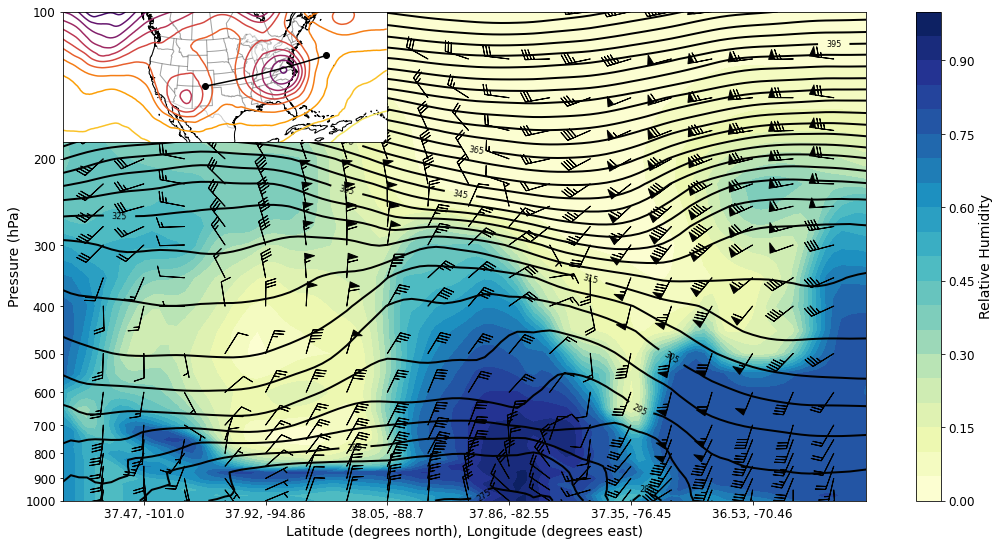

In [9]:
fig = plt.figure(1, figsize=(18, 9))
ax = plt.axes()

rh_contour = ax.contourf(
    cross["index"],
    cross["isobaric"],
    cross["Relative_humidity"],
    levels=np.arange(0, 1.05, 0.05),
    cmap="YlGnBu",
)
rh_colorbar = fig.colorbar(rh_contour)

theta_contour = ax.contour(
    cross["index"],
    cross["isobaric"],
    cross["Potential_temperature"],
    levels=np.arange(250, 450, 5),
    colors="k",
    linewidths=2,
)
theta_contour.clabel(
    theta_contour.levels[1::2],
    fontsize=8,
    colors="k",
    inline=1,
    inline_spacing=8,
    fmt="%i",
    rightside_up=True,
    use_clabeltext=True,
)

wind_slc_vert = list(range(0, 19, 2)) + list(range(19, 29))
wind_slc_horz = slice(5, 100, 5)
ax.barbs(
    cross["index"][wind_slc_horz],
    cross["isobaric"][wind_slc_vert],
    cross["t_wind"][wind_slc_vert, wind_slc_horz],
    cross["n_wind"][wind_slc_vert, wind_slc_horz],
    color="k",
)

xticks = np.arange(10, 100, 15)
ax.set_xticks(xticks)

ax.set_yscale("symlog")
ax.set_ylim(cross["isobaric"].max(), cross["isobaric"].min())
ax.set_yticks(np.arange(1000, 50, -100))

data_crs = data["Geopotential_height"].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.654, 0.25, 0.25], projection=data_crs)

ax_inset.contour(
    data["x"],
    data["y"],
    data["Geopotential_height"].sel(isobaric=500.0),
    levels=np.arange(5100, 6000, 60),
    cmap="inferno",
)

endpoints = data_crs.transform_points(
    ccrs.Geodetic(), *np.vstack([start, end]).transpose()[::-1]
)
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c="k", zorder=2)
ax_inset.plot(cross["x"], cross["y"], c="k", zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(
    cfeature.STATES.with_scale("50m"), edgecolor="k", alpha=0.2, zorder=0
)

# Set the titles and axes labels
# ax_inset.set_title('')

ax.set_xticklabels(
    [
        f"{lat:.4}, {lon:.4}"
        for (lat, lon) in zip(
            cross["lat"].sel(index=xticks).values, cross["lon"].sel(index=xticks).values
        )
    ]
)
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylabel(f"Pressure (hPa)")
ax.set_xlabel("Latitude (degrees north), Longitude (degrees east)")
rh_colorbar.set_label("Relative Humidity")

#### draft caption
Vertical cross section of relative humidity (shaded, dimensionless), potential temperature (contours, K), and wind (barbs, knots) components tangential and normal to the plane of the cross section. Latitude, longitude coordinates along the cross section path are provided along the x-axis, vertical pressure levels are provided along the y-axis. Inset (top-left corner) is a map of the trace of the cross-section and contours of 500 hPa geopotential height. Data from North American Regional Reanalysis (NARR) valid April 04 1987 1800UTC.